# Dzień 2

### - Feature Selection
### - Pipelines
### - GridSearch / Hyper Parameter Selection
### - Cross Validation
### - Random Forest
### - XGBoost
---

# Feature Selection

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

wine_data = load_wine()
wine_df = pd.DataFrame(
    data=wine_data.data, 
    columns=wine_data.feature_names)
wine_df['target'] = wine_data.target

In [ ]:
wine_df

In [ ]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    stratify=y)


### - `shuffle` - dane mają być losowo "potasowane"
### - `stratify`  - poszczególne klasy mają być reprezentowane proporcjonalnie w zbiorze testowym


In [ ]:
X_train.var(axis=0)

In [ ]:
from sklearn.preprocessing import Normalizer
norm = Normalizer().fit(X_train)
norm_X_train = norm.transform(X_train)
norm_X_train.var(axis=0)

### Eliminacja kolumn o niskiej zmienności

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold = 1e-6)
selected_features = selector.fit_transform(norm_X_train)
selected_features.shape

## "Ręczne" zrzucanie kolumn

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

preds = dt.predict(X_test)
f1_score_all = round(f1_score(y_test, preds, average='weighted'),3)
print(f1_score_all)

X_train_sel = X_train.drop(['hue', 'nonflavanoid_phenols'], axis=1)
X_test_sel = X_test.drop(['hue', 'nonflavanoid_phenols'], axis=1)
dt.fit(X_train_sel, y_train)
preds_sel = dt.predict(X_test_sel)
f1_score_sel = round(f1_score(y_test, preds_sel, average='weighted'), 3)
f1_score_sel

## Zrzucanie kolumn testem $\chi^2$

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
f1_score_list = []
for k in range(1, 14):
    selector = SelectKBest(chi2, k=k)
    selector.fit(X_train_v2, y_train_v2)
    
    sel_X_train_v2 = selector.transform(X_train_v2)
    sel_X_test_v2 = selector.transform(X_test_v2)
    
    dt.fit(sel_X_train_v2, y_train_v2)
    kbest_preds = dt.predict(sel_X_test_v2)
    f1_score_kbest = round(f1_score(y_test, kbest_preds, average='weighted'), 3)
    f1_score_list.append(f1_score_kbest)

print(f1_score_list)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
x = list(range(0,13))
y = f1_score_list
ax.bar(x, y, width=0.4)
ax.set_xlabel('Ilość wymiarów wybranych testem chi2')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

## Syntetyczne dane klasyfikacyjne

In [ ]:
from sklearn.datasets import make_classification

X, y= make_classification(n_samples=1000, n_features=20, n_informative=5, n_redundant=5, n_repeated=5, n_classes=2)


X = pd.DataFrame(X)
X = X.applymap(abs)
X

In [ ]:
y

---
# <span style="color: magenta">Ćwiczenie - w powyższym zbiorze jest 5 przydatnych kolumn. Zastosować mechanizmy selekcji wymiarów do redukcji w/w tabeli do 5 wymiarów</span>
---

## Recursive Feature Elimination

### - korzystając z osobnego estymatora posiadającego `coef_` lub `feature_importance_` iteracyjnie odrzucane są kolejne wagi

In [ ]:
from sklearn.feature_selection import RFE

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
RFE_selector = RFE(estimator=dt, n_features_to_select=4, step=1)
RFE_selector.fit(X_train_v3, y_train_v3)

In [ ]:
X_train_v3.columns[RFE_selector.support_]

In [ ]:
sel_X_train_v3 = RFE_selector.transform(X_train_v3)
sel_X_test_v3 = RFE_selector.transform(X_test_v3)
dt.fit(sel_X_train_v3, y_train_v3)
RFE_preds = dt.predict(sel_X_test_v3)
rfe_f1_score = round(f1_score(y_test_v3, RFE_preds, average='weighted'),3)
print(rfe_f1_score)

## Select from model

### - korzystając z osobnego estymatora posiadającego `coef_` lub `feature_importance_` 

In [ ]:
from sklearn.feature_selection import SelectFromModel

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

sfm_selector = SelectFromModel(estimator=DecisionTreeClassifier())
sfm_selector.fit(X_train_v4,  y_train_v4)

In [ ]:
X_train_v4.columns[sfm_selector.get_support()]

In [ ]:
sel_X_train_v4 = sfm_selector.transform(X_train_v4)
sel_X_test_v4 = sfm_selector.transform(X_test_v4)

dt.fit(sel_X_train_v4, y_train_v4)
sfm_preds = dt.predict(sel_X_test_v4)
sfm_f1_score = round(f1_score(y_test_v4, sfm_preds, average='weighted'),3)
print(rfe_f1_score)

---
# <span style="color: magenta">Ćwiczenie - w klasyfikatorze spamu z wczoraj, zredukować ilość wymiarów w `DecisionTreeClassifier`. </span>

# <span style="color: magenta">Ćwiczenie - Wyświetlić tak uproszczone drzewo. </span>
---

# Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

ppln_clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC())),
  ('classification', DecisionTreeClassifier())
])
ppln_clf.fit(X_train, y_train)

In [ ]:
ppln_preds = ppln_clf.predict(X_test)
ppln_f1_score = round(f1_score(y_test, ppln_preds, average='weighted'),3)
ppln_f1_score

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

ppln_clf = Pipeline([
  ('feature_selection', SelectKBest(chi2, k=4)),
  ('classification', DecisionTreeClassifier())
])
ppln_clf.fit(X_train, y_train)

In [ ]:
ppln_preds = ppln_clf.predict(X_test)
ppln_f1_score = round(f1_score(y_test, ppln_preds, average='weighted'),3)
ppln_f1_score

---
# <span style="color: magenta">Ćwiczenie - Przerobić kod z poprzedniego ćwiczenia w `pipeline` </span>
---

In [22]:
import pandas as pd

data = pd.read_csv('data/adverts_29_04.csv', sep=';')
data['cena_za_metr'] = data['Cena'] / data['Wielkość (m2)']
data = data.dropna(subset=['cena_za_metr'])
df = data.drop(['Cena', 'Data dodania'], axis=1)
df

,Lokalizacja,Na sprzedaż przez,Rodzaj nieruchomości,Liczba pokoi,Liczba łazienek,Wielkość (m2),opis,Parking,cena_za_metr
0,"Praga Północ, Warszawa",Właściciel,Mieszkanie,4 pokoje,1 łazienka,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,NaN,10380.000000
1,"Wilanów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,Ulica,11679.245283
2,"Wilanów, Warszawa",Właściciel,Mieszkanie,3 pokoje,2 łazienki,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,Garaż,10555.555556
3,"Śródmieście, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,Brak,11909.090909
4,"Wola, Warszawa",Agencja,Mieszkanie,2 pokoje,1 łazienka,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",NaN,12805.511111
...,...,...,...,...,...,...,...,...,...
982,"Bemowo, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,NaN,9445.945946
983,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",NaN,9772.727273
984,"Wawer, Warszawa",Agencja,Dom,4 pokoje,NaN,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,NaN,8625.000000
985,"Bemowo, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,NaN,7794.520548


In [23]:
dum_df = pd.get_dummies(df, columns=['Lokalizacja', 'Na sprzedaż przez', 'Rodzaj nieruchomości', 'Liczba pokoi', 'Liczba łazienek', 'Parking'])
dum_df

,Wielkość (m2),opis,cena_za_metr,"Lokalizacja_Bemowo, Warszawa","Lokalizacja_Białołęka, Warszawa","Lokalizacja_Bielany, Warszawa","Lokalizacja_Mokotów, Warszawa","Lokalizacja_Ochota, Warszawa","Lokalizacja_Praga Południe, Warszawa","Lokalizacja_Praga Północ, Warszawa",...,Liczba pokoi_6 lub więcej pokoi,Liczba pokoi_Kawalerka lub garsoniera,Liczba łazienek_1 łazienka,Liczba łazienek_2 łazienki,Liczba łazienek_3 łazienki,Liczba łazienek_4 lub więcej łazienek,Parking_Brak,Parking_Garaż,Parking_Kryty,Parking_Ulica
0,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,10380.000000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,11679.245283,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,10555.555556,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,11909.090909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",12805.511111,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,9445.945946,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
983,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",9772.727273,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,8625.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,7794.520548,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
dum_df.columns

Index(['Wielkość (m2)', 'opis', 'cena_za_metr', 'Lokalizacja_Bemowo, Warszawa',
       'Lokalizacja_Białołęka, Warszawa', 'Lokalizacja_Bielany, Warszawa',
       'Lokalizacja_Mokotów, Warszawa', 'Lokalizacja_Ochota, Warszawa',
       'Lokalizacja_Praga Południe, Warszawa',
       'Lokalizacja_Praga Północ, Warszawa', 'Lokalizacja_Rembertów, Warszawa',
       'Lokalizacja_Targówek, Warszawa', 'Lokalizacja_Ursus, Warszawa',
       'Lokalizacja_Ursynów, Warszawa', 'Lokalizacja_Wawer, Warszawa',
       'Lokalizacja_Wesoła, Warszawa', 'Lokalizacja_Wilanów, Warszawa',
       'Lokalizacja_Wola, Warszawa', 'Lokalizacja_Włochy, Warszawa',
       'Lokalizacja_Śródmieście, Warszawa', 'Lokalizacja_Żoliborz, Warszawa',
       'Na sprzedaż przez_Agencja', 'Na sprzedaż przez_Właściciel',
       'Rodzaj nieruchomości_Dom', 'Rodzaj nieruchomości_Inne',
       'Rodzaj nieruchomości_Mieszkanie', 'Liczba pokoi_2 pokoje',
       'Liczba pokoi_3 pokoje', 'Liczba pokoi_4 pokoje',
       'Liczba pokoi_5 pokoi

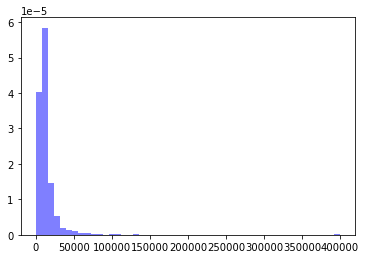

In [25]:
import matplotlib.pyplot as plt

plt.hist(dum_df['cena_za_metr'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [26]:
dum_df.drop(dum_df[dum_df.cena_za_metr >30000.0].index, inplace=True)

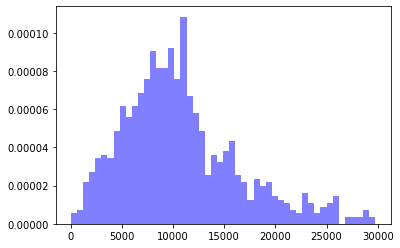

In [27]:
import matplotlib.pyplot as plt

plt.hist(dum_df['cena_za_metr'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [28]:
dum_df.corr()['cena_za_metr']

Wielkość (m2)                           -0.064497
cena_za_metr                             1.000000
Lokalizacja_Bemowo, Warszawa            -0.018889
Lokalizacja_Białołęka, Warszawa         -0.159826
Lokalizacja_Bielany, Warszawa            0.003766
Lokalizacja_Mokotów, Warszawa            0.131210
Lokalizacja_Ochota, Warszawa            -0.018932
Lokalizacja_Praga Południe, Warszawa     0.002441
Lokalizacja_Praga Północ, Warszawa       0.021179
Lokalizacja_Rembertów, Warszawa         -0.100811
Lokalizacja_Targówek, Warszawa          -0.036512
Lokalizacja_Ursus, Warszawa             -0.074461
Lokalizacja_Ursynów, Warszawa           -0.062382
Lokalizacja_Wawer, Warszawa             -0.141669
Lokalizacja_Wesoła, Warszawa            -0.151450
Lokalizacja_Wilanów, Warszawa           -0.085052
Lokalizacja_Wola, Warszawa               0.055272
Lokalizacja_Włochy, Warszawa            -0.031444
Lokalizacja_Śródmieście, Warszawa        0.323234
Lokalizacja_Żoliborz, Warszawa           0.045081


## Mapa ciepła korelacji parametrów

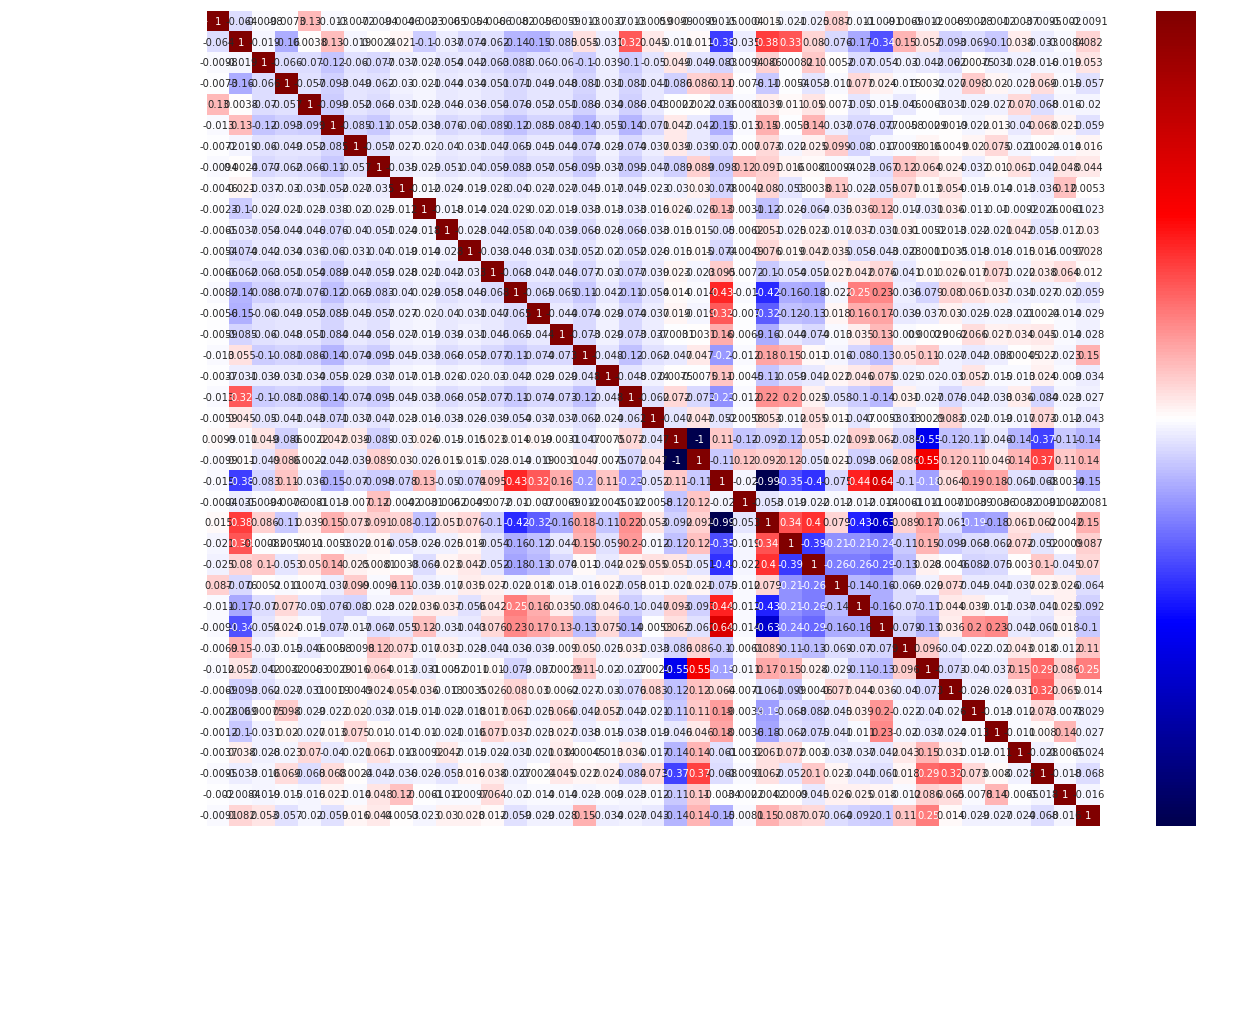

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(20,15))
plt.style.use("dark_background")

sns.heatmap(dum_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

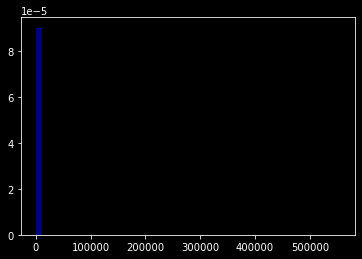

In [30]:
plt.hist(dum_df['Wielkość (m2)'], 50,
         density=True,
         histtype='bar',
         facecolor='b',
         alpha=0.5)

plt.show()

In [31]:
dum_df.drop(dum_df[dum_df['Wielkość (m2)'] >300.0].index, inplace=True)
dum_df

,Wielkość (m2),opis,cena_za_metr,"Lokalizacja_Bemowo, Warszawa","Lokalizacja_Białołęka, Warszawa","Lokalizacja_Bielany, Warszawa","Lokalizacja_Mokotów, Warszawa","Lokalizacja_Ochota, Warszawa","Lokalizacja_Praga Południe, Warszawa","Lokalizacja_Praga Północ, Warszawa",...,Liczba pokoi_6 lub więcej pokoi,Liczba pokoi_Kawalerka lub garsoniera,Liczba łazienek_1 łazienka,Liczba łazienek_2 łazienki,Liczba łazienek_3 łazienki,Liczba łazienek_4 lub więcej łazienek,Parking_Brak,Parking_Garaż,Parking_Kryty,Parking_Ulica
0,50.0,CO] - gotowiec inwestycyjny KUP I ZARABIAJ \n\...,10380.000000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,53.0,Sprzedam mieszkanie 2 pokoje 53m2 w\r\nMiastec...,11679.245283,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,90.0,Sprzedam komfortowo urządzone mieszkanie o pow...,10555.555556,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,55.0,Agencja WN pracuje podczas pandemii. Prowadzim...,11909.090909,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,45.0,"BLISKA WOLA , komfortowy 2- pokojowy apartamen...",12805.511111,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,74.0,Mieszkanie Bemowo przy budowanym metrze\n\nNa ...,9445.945946,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
983,66.0,"Blok z wielkiej płyty z roku 1992, PO REMONCIE...",9772.727273,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984,160.0,Na sprzedaż nowoczesny dom 4-pokojowy w zabud...,8625.000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
985,73.0,Na sprzedaż mieszkanie w apartamentowcu wybud...,7794.520548,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
# Regresja

In [ ]:
from sklearn.linear_model import LinearRegression

y = dum_df['cena_za_metr']
X = dum_df.drop(['opis', 'cena_za_metr'], axis=1)

reg = LinearRegression().fit(X, y)

In [ ]:
reg.score(X, y)

# $R^2$

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)https://en.wikipedia.org/wiki/Coefficient_of_determination

Współczynnik determinacji - Jaka część wariancji zmiennej objaśnianej jest pochodzi od zmiennych tłumaczących

- 1.0 - Idealnie dopasowania
- 0.0 - Funkcja stała
- ... ale może być i ujemna

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

---
## Walidacja krzyżowa

![Walidacja krzyżowa](img\xvi.png)

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
scores = cross_val_score(LinearRegression(), X_train, y_train, cv=10)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Zmiana techniki scoringu

In [ ]:
from sklearn.metrics import mean_squared_error, make_scorer


scores = cross_val_score(LinearRegression(), X_train, y_train, scoring=make_scorer(mean_squared_error), cv=5)
print(list(scores))
print()
print("Mean square error: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Zmiana regresora

In [ ]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=1000), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=10), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='linear', C=100), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.svm import SVR

scores = cross_val_score(SVR(kernel='rbf', C=1000), X_train, y_train, cv=5)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

scores = cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv=10)
print(list(scores))
print()
print("Mean r^2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

## Hiperparametry
### `C` - współczynnik regularyzacji - odwrotność siły regularyzacji czyli __*"czynienia rozwiązania prostszym"*__


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("dark_background")
plt.figure(figsize=(10,6))
x = np.linspace(-0.5, 2, 100)
plt.plot(x, x*(5*x-1)*(x-2))
y = np.linspace(0, 1.4, 3)
plt.scatter(y, -3.4*y, color="#FF00FF");
z = np.linspace(-0.5, 2, 50)
plt.plot(z, -3.4*z-0.3);

## GridSearch elementów `Pipeline`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from warnings import simplefilter
simplefilter(action='ignore', category=DeprecationWarning)

pipe = Pipeline([
    ('scale',  'passthrough'),
    ('regression', SVR())
])



In [ ]:
pipe.set_params(regression__C=10)

In [ ]:
param_grid = dict(regression__C=[0.1, 1.0, 10, 100])

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid, verbose=1, cv=3)
grid_search

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_estimator_)

In [ ]:
grid_search.best_score_

## Scalers
- StandardScaler (standardyzacja - odejmuję średnia, dzieli przez wariancję)
- Normalizer (normalizacja - dzieli przez długość - sprowadza do wektora o normie 1)
- RobustScaler (odejmuje medianę i skaluje kwartylami)

In [ ]:
from time import time

param_grid = dict( 
    scale=['passthrough', StandardScaler(), Normalizer()],
    regression__C=[ 10, 100],
    regression__kernel=['linear']
)
                  
print(param_grid)

###################################

grid_search = GridSearchCV(pipe, param_grid, verbose=1, cv=5, n_jobs=2)

###################################

t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()
print("Best parameters set:")
print(grid_search.best_estimator_)
print()
print(f"Best score: {grid_search.best_score_}")

- 5 - Walidacja krzyżowa
- 2 - parametry $C$
- 3 - scaler

$ 5 * 2 * 3 = 30 $ przebiegów

---
# Random Forest Classifier

https://www.kaggle.com/datasets/yufengsui/portuguese-bank-marketing-data-set

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

C:\Users\sesa443784\Miniconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
bank_data = pd.read_csv('data/bank-full.csv', sep=';')
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Binaryzacja 

In [3]:
bank_data['default'] = bank_data['default'].map({'no':0,'yes':1,'unknown':0})

bank_data['y'] = bank_data['y'].map({'no':0,'yes':1})
bank_data['housing'] = bank_data['housing'].map({'no':0,'yes':1})
bank_data['loan'] = bank_data['loan'].map({'no':0,'yes':1})
bank_data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,508,4,-1,0,unknown,0


## Konwersja zmiennych kategorycznych

In [4]:
bank_data = pd.get_dummies(bank_data, columns=['job', 'marital', 'education', 'contact', 'month', 'poutcome'])
bank_data

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,261,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,151,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,76,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,92,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,198,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,17,977,3,-1,0,...,0,0,0,1,0,0,0,0,0,1
45207,71,0,1729,0,0,17,456,2,-1,0,...,0,0,0,1,0,0,0,0,0,1
45208,72,0,5715,0,0,17,1127,5,184,3,...,0,0,0,1,0,0,0,0,1,0
45209,57,0,668,0,0,17,508,4,-1,0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
X = bank_data.drop('y', axis=1)
y = bank_data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [8]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9073316377308416


## Wiele estymatorów

In [9]:
len(rf.estimators_)

100

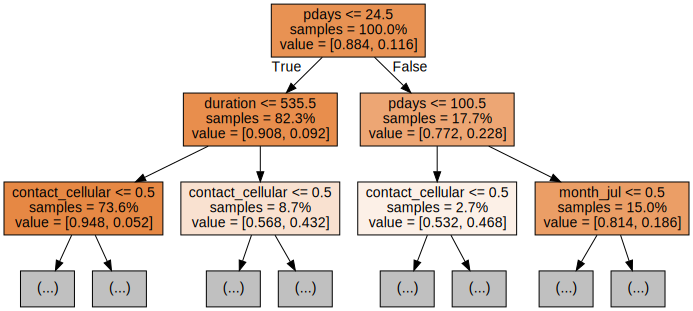

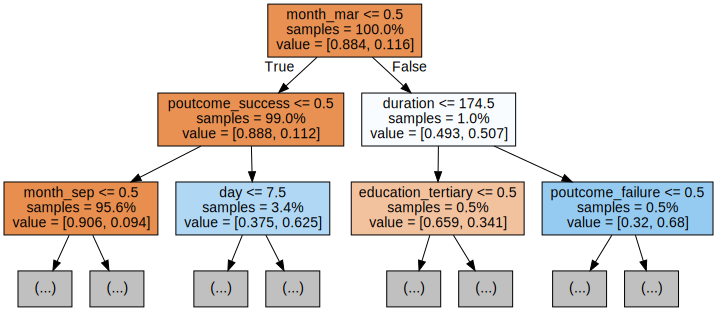

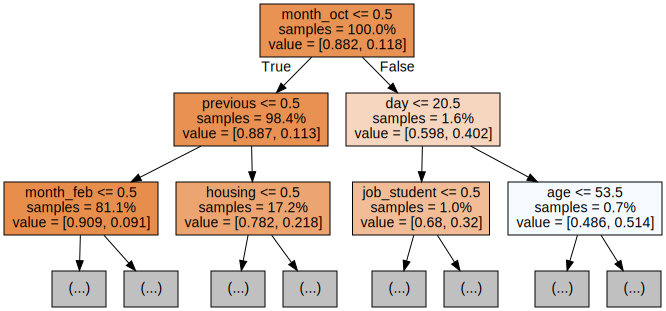

In [10]:

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## `RandomizedSearchCV`

In [11]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5, n_jobs=3)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5, n_jobs=3,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000117D85594F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000117D8540220>})

## Najlepszy estymator

In [12]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 386}


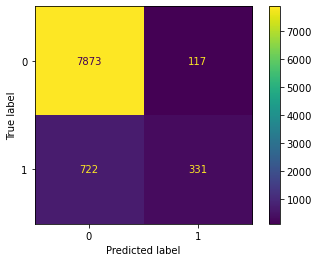

In [13]:
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9072210549596373


# Grid Strategies
- ## HalvingGridSearchCV
  - Przeszukiwanie przez podział binarny

- ## RandomizedSearchCV
  - W odróżnieniu do `GridSearchCV`, nie wszystkie parametry są sprawdzane, ale `n_iter` z pewnego rozkładu
  - Jeśli parametry są na liście - korzystamy z losowania bez zwracania 
  
- ## HalvingRandomSearchCV
  - Parametry są przeszukiwane losowo z coraz węższego zakresu
  
- ## <span style="color: cyan">auto-sklearn</span> 
  - używa nauczana maszynowego do wyboru algorytmu i dobrania hiperparametrów


---
# XGBoost

conda install -c conda-forge xgboost

In [15]:
!conda install -y -c conda-forge xgboost

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




## <span style="color: cyan">- Numeric features should be scaled </cyan>
## <span style="color: cyan">- Categorical features should be encoded </cyan>

# Random Forest

- ## Bagging  "Bootstrap Aggregating" - równorzędne modele na podzbiorach modelu trenującego. Wynik jest średnią z wyników
- ## Dobry dla zaszumionych zbiorów
- ## Dobre dla high variance and low bias - Wyniki są STABILNE
- ## Tendencje do overfittingu


# XGBoost

- ## Boosting - model jest zbudowany z serii coraz to lepszych modeli które dodają swój wynik do porzedniego. 
- ## Dobry dla niezbalansowanych zbiorów
- ## Dobre dla modeli low variance and high bias - Wyniki są DOKŁADNE
- ## Dobrze uogólnia

---

https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
    

In [1]:
import pandas as pd

rain = pd.read_csv("data/weatherAUS.csv")
rain

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [2]:
cols_to_drop = ["Date", "Location", "RainTomorrow", "Rainfall"]

rain.drop(cols_to_drop, axis=1, inplace=True)

## Usuwamy kolumny z dużą ilością `NaN`

In [3]:
missing_props = rain.isna().mean(axis=0)

over_threshold = missing_props[missing_props >= 0.4]

In [4]:
rain.drop(over_threshold.index, 
          axis=1, 
          inplace=True)

In [5]:
rain['RainToday'] = rain['RainToday'].map({'No':0,'Yes':1})

In [6]:
X = rain.drop("RainToday", axis=1)
y = rain.RainToday

In [7]:
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
145455    0.0
145456    0.0
145457    0.0
145458    0.0
145459    0.0
Name: RainToday, Length: 145460, dtype: float64

In [8]:
X

,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Temp9am,Temp3pm
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,16.9,21.8
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,17.2,24.3
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,21.0,23.2
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,18.1,26.5
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,17.8,29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2.8,23.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,10.1,22.4
145456,3.6,25.3,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,10.9,24.5
145457,5.4,26.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,12.5,26.1
145458,7.8,27.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,15.1,26.0


## Uzupełniamy braki w kategorycznych kolumnach

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("oh-encode", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

C:\Users\sesa443784\Miniconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Uzupełniamy braki w kolumnach liczbowych

In [10]:
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), 
           ("scale", StandardScaler())]
)

In [11]:

cat_cols = X.select_dtypes(exclude="number").columns
num_cols = X.select_dtypes(include="number").columns

In [12]:
from sklearn.compose import ColumnTransformer

full_processor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, num_cols),
        ("categorical", categorical_pipeline, cat_cols),
    ]
)

In [13]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()

In [14]:
X_processed = full_processor.fit_transform(X)
y_processed = SimpleImputer(strategy="most_frequent").fit_transform(
    y.values.reshape(-1, 1)
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, stratify=y_processed, random_state=1121218
)

C:\Users\sesa443784\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
from sklearn.metrics import accuracy_score

xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(X_train, y_train)

preds = xgb_cl.predict(X_test)

accuracy_score(y_test, preds)


0.8507080984463082

## Grid Search

https://xgboost.readthedocs.io/en/stable/parameter.html

- `eta` / `learning_rate` - redukcja kroku aby uniknąć przetrenowania - `[0,1]`
- `gamma` - minimalny strata potrzebna do kolejnego kroku. Większy parametr - algorytm jest bardziej konserwatywny - `[0, Infty]`
- `max_depth` - maksymalna głębokość drzewa
- `subsample` - jaka część danych jest brana do trenowania przy kolejnych krokach
- `sampling_method` - jaka strategia samplingu
- `colsample_*` - rodzina parametrów regulująca subsampling
- `lambda` / `reg_lambda` - waga cech. Większy parametr - algorytm jest bardziej konserwatywny - `[0, Infty]`
- `scale_pos_weight` - ważenie niezbalansowanych klas
- `early_stopping_rounds`
- = 5

https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

#### Sterowanie złożonością modelu:

    - Złożonośc modelu: `max_depth`, `gamma`, `min_child_weight`
    - Wprowadzenie szumu: `subsample`, `colsample_by_tree`
    - Tempo uczenia: `eta` , `num_round`

In [16]:
param_grid = {
#     "max_depth": [3, 4, 5, 7],
    "max_depth": [3, 4],
#     "learning_rate": [0.1, 0.01, 0.05],
    "learning_rate": [0.1],
    "gamma": [0.25],
#     "gamma": [0, 0.25, 1],
    "reg_lambda": [ 1],
#     "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [3],
#     "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}

In [17]:
from sklearn.model_selection import GridSearchCV

xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=4)

_ = grid_cv.fit(X_processed, y_processed)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [18]:
 grid_cv.best_score_

0.8516135920014952

----

In [19]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'subsample': 0.8}

# <span style="color: magenta">Ćwiczenie - dobrać jeszcze lepsze parametry (dla tych z końców zakresu) </span>

# <span style="color: magenta">Ćwiczenie - stworzyć klasyfikator w oparciu o ulepszone parametry. Podać jego skuteczność na zbiorze testowym.</span>


---

# Pipeline dla tekstu

In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer 

data = pd.read_csv('data/adverts_29_04.csv', sep=';')
data['cena_za_metr'] = data['Cena'] / data['Wielkość (m2)']
data = data.dropna(subset=['cena_za_metr'])
df = data.drop(['Cena', 'Data dodania'], axis=1)
df

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(df["opis"])
tfs

<986x16331 sparse matrix of type '<class 'numpy.float64'>'
	with 170858 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


pipeline = Pipeline([
                ('selector', ItemSelector(key='opis')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components=250)),
                ('linear', LinearRegression())
            ])

y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
scores = cross_val_score(pipeline, X_train, y_train, cv=3)
print(list(scores))
print()
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

parameters = parameters = {
    'best__n_components': (250,),
    'svr__C': (100, 1000),
    'svr__kernel':('linear', 'rbf')
}

pipeline = Pipeline([
                ('selector', ItemSelector(key='opis')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD()),
                ('svr', SVR())
            ])

grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=3, n_jobs=2)


y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from operator import itemgetter

vectorizer = TfidfVectorizer(min_df=2)

X = vectorizer.fit_transform(X_train['opis'])



In [ ]:
import gzip
import sys
import re
import re

splitter = re.compile(r'[^ąąćęńłóóśśżżź\w]+')
isnumber = re.compile(r'[0-9]')

f = gzip.open('data/odm.txt.gz', 'rt', encoding='utf-8')
dictionary = {}
set_dict= set()

for x in f:
    t = x.strip().split(',')
    tt = [ x.strip().lower() for x in t]
    for w in tt:
        set_dict.add(w)
        dictionary[w]=tt[0]

def lematize(w):
    w = w.replace('ą','ą')
    w = w.replace('ó','ó')
    w = w.replace('ę','ę')
    w = w.replace('ż','ż')
    return dictionary.get(w,w)

opis1 = dum_df['opis'][0]



raw_corpus=[]
n=0

for i in dum_df.iterrows():
    n+=1
    l = list(splitter.split(i[1][1]))
    raw_corpus.append(l)

    
all_words = []
for t in raw_corpus:
    all_words[0:0] = t

words = {}
for w in all_words:
    rec = words.get(w.lower(), {'upper':0, 'lower': 0})
    if w.lower()==w or w.upper()==w:
        rec['lower'] = rec['lower'] +1
    else: 
        rec['upper'] = rec['upper'] +1
    words[w.lower()] = rec

raw_stop_words = [ x for x in words.keys() if words[x]['upper']>=words[x]['lower']*4 ]   

set_raw_stop_words = set(raw_stop_words)



In [ ]:
raw_stop_words[:20]

In [ ]:
def preprocessing(opis, filter_raw=True, filter_dict=True):
    opis = str(opis)
    tokenized = splitter.split(opis)
    l = list(tokenized)
    l = [ x.lower() for x in l ]
    l = [ x for x in l if len(x) > 2]
    l = [ x for x in l if x.find('_') < 0]
    l = [ x for x in l if isnumber.search(x) is None ]
    if filter_raw: l = [ x for x in l if x not in set_raw_stop_words ]
    if filter_dict: l = [ x for x in l if x in set_dict ]
    l = [ lematize(x) for x in l ]
    l = [ x for x in l if len(x) > 2]
    return l

In [ ]:
opis1

In [ ]:
print(preprocessing(opis1))

In [ ]:
print(preprocessing(opis1, filter_raw=False))

In [ ]:
print(preprocessing(opis1, filter_dict=False))

In [ ]:
print(preprocessing(opis1, filter_raw=False, filter_dict=False))

In [ ]:
dum_df["opisTT"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=True, filter_dict=True)))
dum_df["opisTF"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=True, filter_dict=False)))
dum_df["opisFT"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=False, filter_dict=True)))
dum_df["opisFF"] = dum_df["opis"].apply(lambda x: ' '.join(preprocessing(x,filter_raw=False, filter_dict=False)))

---
# Pipeline kompozytowy

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import FeatureUnion

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key=''):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class ItemUnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys=[]):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict.drop(self.keys, axis=1)


pipeline = Pipeline([
   ('union', 
        FeatureUnion(
            transformer_list=[
                ('table', 
                    Pipeline([
                        ('selector1', ItemUnSelector(keys=['opis', 'opisTT', 'opisTF', 'opisFT', 'opisFF'])),
                        ('scaler1', 'passthrough')
                    ])
                ),
                ('description', 
                    Pipeline([
                        ('selector2', ItemSelector()),
                        ('tfidf', TfidfVectorizer()),
                        ('best', TruncatedSVD()),
                        ('scaler2', 'passthrough')
                    ])
                )
            ]
        )    

   ),
   ('regressor', 
        TransformedTargetRegressor()
    )
])

parameters = parameters = {
    'union__transformer_weights': [  { 'table': 1.0, 'description': 1.0}],

    'union__description__best__n_components': (700,),
    'union__description__tfidf__min_df': (3,),
    'union__description__tfidf__binary': (True,),
    'union__description__selector2__key': [ 'opisFF'] ,
    
    'union__table__scaler1': [ RobustScaler()],
    'union__description__scaler2': [ RobustScaler(with_centering=False)],
    
    'regressor': [ GradientBoostingRegressor()] ,
}

grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=10, n_jobs=4)


y = dum_df['cena_za_metr']
X = dum_df.drop(['cena_za_metr'], axis=1)

t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))

print(f'Best score: {grid_search.best_score_}')

print("Best parameters set:")
print()
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

---
## Problemy z trenowaniem modelu


### To ile tych prób możemy mieć ?

- 3 zestawy wag `union`
- 6 zestawów wymiarów SVD
- 6 zestawów parametrów TF-IDF
- 4 zbiory danych tekstowych
- 4 mechanizmy skalowania części `table`
- 4 mechanizmy skalowania części `description`
- 3 regresory
- 10 walidacji krzyżowych

In [ ]:
3*6*6*4*4*4*3*10

powiedzmy - że 3 na minutę

In [ ]:
3*6*6*4*4*4*3*10/3/60/24

---

# Podsumowanie

- ## Inżynieria cech i przygotowanie danych to zestaw arbitralnych decyzji
- ## Te decyzje muszą być walidowane
- ## __*Inżynieria cech*__ jest częścią modelu
- ## Uwaga na <span style="color: red">Eksplozję kombinatoryczną</span>

# Bibliografia
- ## [Efficient and Robust Automated Machine Learning](https://papers.nips.cc/paper/5872-efficient-and-robust-automated-machine-learning.pdf) - __*Matthias Feurer, Aaron Klein, Katharina Eggensperger, Jost Springenberg, Manuel Blum and Frank Hutter*__ Advances in Neural Information Processing Systems 28 (2015)